In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint, rand
from sklearn.preprocessing import scale

In [2]:
Y = pd.read_csv('/content/Acinar_featureSelected2_Modified.csv', index_col=[0]).T.values
mData = pd.read_csv('/content/Acinar_metadata2_modified.csv', index_col=[0])

In [3]:
Y = scale(Y)

In [4]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))


Time Points: 312, Genes: 500


In [5]:
df = pd.DataFrame(Y)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.362926,1.599798,-0.416372,-1.959670,0.760892,0.776110,1.110125,0.901240,0.567182,0.444226,...,-1.119477,2.217349,-0.328305,-0.631085,0.162304,-0.608401,-0.317934,-0.244837,-0.441237,-0.309244
1,0.594900,1.112111,0.383662,0.287562,0.817143,0.779536,1.094516,0.556415,0.934950,0.750247,...,0.808834,-0.341880,-0.328305,-0.631085,-0.259131,-0.608401,-0.317934,-0.244837,-0.441237,-0.309244
2,-1.170451,1.224885,0.638970,0.801416,0.690680,0.692768,1.118148,0.716353,0.614490,0.371066,...,-1.119477,-0.341880,-0.328305,-0.631085,-1.094125,0.925082,-0.317934,-0.244837,-0.441237,-0.309244
3,0.097047,1.322801,0.688290,0.717855,0.766326,0.757674,0.946933,0.689517,0.729883,0.469766,...,-1.119477,-0.341880,-0.328305,-0.631085,-1.094125,-0.608401,-0.317934,-0.244837,-0.441237,-0.309244
4,-1.170451,1.196232,0.511829,0.386545,0.699534,0.722234,0.899606,0.515527,0.515710,0.271840,...,-1.119477,-0.341880,-0.328305,-0.631085,-1.094125,2.162317,-0.317934,-0.244837,-0.441237,-0.309244


In [6]:
# print(len(mData['donor_age'].values))
mData.shape
#mData['donor_age'].values

(312, 5)

In [7]:
n_pop = N * 4
np.random.seed(10)
sigma_t = 4.
prior_mean = mData['donor_age'].values
print(type(prior_mean))
# N = 5
pop = [np.asanyarray([prior_mean[i] + sigma_t * np.random.randn(1) for i in range(0, N)]).reshape(-1) for _ in range(0, n_pop)]
# np.array(prior_mean).shape
# pop

<class 'numpy.ndarray'>


In [ ]:
len(prior_mean)

312

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from math import log

def objectiveFunction(x):
    x = x[:,None]
    x_3 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
    mse3 = 0

    for i in range(0, D):
        y = Y[:,i]
        model3 = LinearRegression().fit(x_3, y)

        # predict the training set
        yhat3 = model3.predict(x_3)

        # calculate the error
        mse3 += ((y-yhat3)**2).mean(axis=0)

    del  model3, y, yhat3, x, x_3

    return mse3


# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

In [9]:
# crossover two parents to create two children
def crossover(p1, p2, r_cross=0.9):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = np.concatenate( (p1[:pt], p2[pt:]), axis=None)
        c2 = np.concatenate( (p2[:pt], p1[pt:]), axis=None)

    return [c1, c2]

# mutation operator
def mutation(offSpring, r_mut=0.05):
    sigma_mu = 2.
    for i in range(0, len(offSpring)):
        # check for a mutation
        if rand() < r_mut:
            offSpring[i] = offSpring[i] + sigma_mu * np.random.randn(1)

In [ ]:
n_iter = 100
best, best_eval = 0, objectiveFunction(pop[0])
# print(best_eval)
for gen in range (0, n_iter):
    scores = [objectiveFunction(c) for c in pop]
    for j in range(0,n_pop):
        if scores[j] < best_eval:
            best, best_eval = pop[j], scores[j]
#     print(">%d, new best f(%s) = %.3f" % (gen,  best, best_eval))
    print(">%d, new best_eval = %.3f" % (gen, best_eval))

    # select parents
    selected = [selection(pop, scores) for _ in range(0,n_pop)]
#     print("Selected")
#     print(len(selected))
#     print(selected)
    # create the next generation
    children = list()
    for i in range(0, n_pop, 2):
        # get selected parents in pairs
        p1, p2 = selected[i], selected[i]
        # crossover and mutation
        for c in crossover(p1, p2, r_cross=0.82):
#             # mutation
            mutation(c, r_mut=0.08)
#             # store for next generation
            children.append(c)
#     print(len(children))
#     # replace population
    pop = children
#     return [best, best_eval]
print(best, best_eval)

>0, new best_eval = 460.450
>1, new best_eval = 460.450
>2, new best_eval = 460.327
>3, new best_eval = 460.327
>4, new best_eval = 460.204
>5, new best_eval = 460.029
>6, new best_eval = 459.929
>7, new best_eval = 459.929
>8, new best_eval = 459.829
>9, new best_eval = 459.563
>10, new best_eval = 459.235
>11, new best_eval = 459.087
>12, new best_eval = 458.839


In [ ]:
best

In [11]:
!pip install rpy2

In [12]:
%load_ext rpy2.ipython

In [9]:
%%R
# Check R version
version_info <- R.version
cat("R version:", paste(version_info$major, version_info$minor, sep = "."), "\n")

R version: 4.3.2 


In [15]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("SingleCellExperiment")

(as ‘lib’ is unspecified)







	‘/tmp/RtmplEhSY9/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com










































































































	‘/tmp/RtmplEhSY9/downloaded_packages’

  'fansi', 'gargle', 'gert', 'haven', 'highr', 'isoband', 'jsonlite',
  'openssl', 'progress', 'ragg', 'roxygen2', 'sass', 'scales', 'svglite',
  'testthat', 'textshaping', 'vctrs', 'vroom', 'whisker', 'xml2', 'boot',
  'cluster', 'Matrix', 'nlme', 'rpart'



Update all/some/none? [a/s/n]: n


In [16]:
%%R
library(SingleCellExperiment)




Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars





Attach

In [17]:
%%R
Acinar_SCE <- SingleCellExperiment(assays = list(counts = t(genesAcinar[,-1])))


In [20]:
%%R
install.packages("ggthemes")
install.packages("ggrepel")
install.packages("ggbeeswarm")

(as ‘lib’ is unspecified)







	‘/tmp/RtmplEhSY9/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmplEhSY9/downloaded_packages’



In [21]:
%%R
library(ggplot2)
library(ggbeeswarm)
library(ggthemes)
library(ggrepel)

In [24]:
%%R
genesAcinar <- read.csv(file = '/content/Acinar_data2.csv')

MData_Acinar <- read.csv(file = '/content/Acinar_metadata2_modified.csv')
pseudotime_Acinar_latest <- read.csv("/content/AcinarWholePseudotime_withDataFromPsupertime.csv")


In [18]:
%%R
age <- MData_Acinar$donor_age

age1<-rep(NA,length(age))
age1[(age==1)]<-0
age1[(age==5)]<-5
age1[(age==6)]<-6
age1[(age==21)]<-21
age1[(age==22)]<-22
age1[(age==38)]<-38
age1[(age==44)]<-44
factor(age1)


  [1] 0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
 [16] 0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
 [31] 0    0    0    0    0    0    0    0    5    5    5    5    5    5    5   
 [46] 5    5    5    5    5    5    5    5    5    5    5    5    5    5    5   
 [61] 5    5    5    5    5    5    5    5    5    5    5    5    5    5    5   
 [76] 5    5    5    5    5    5    5    5    5    5    5    5    5    5    5   
 [91] 5    5    5    5    5    5    5    5    5    5    5    5    5    5    5   
[106] 5    5    5    5    5    5    5    5    5    5    5    5    5    5    5   
[121] 5    6    6    6    6    6    6    6    6    6    6    6    6    6    6   
[136] 6    6    6    6    6    6    6    6    6    6    6    21   21   21   21  
[151] 21   21   21   21   21   21   21   21   21   21   21   21   21   21   21  
[166] 21   21   21   21   21   21   21   21   21   21   21   21   21   21   21  
[181] 21   21   21   21   21

In [26]:
%%R
genes_AC <- t(genesAcinar[,-1])
Acinar_SCE <- SingleCellExperiment(assays = list(counts = t(genesAcinar[,-1])))


In [33]:
%%R

pseudotimeforuse <- (pseudotime_Acinar_latest$X0)
donor_age<- factor(age)
colData(Acinar_SCE)$age<-age
tt<- colData(Acinar_SCE)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Orientation inferred to be along y-axis; override with
`position_quasirandom(orientation = 'x')`


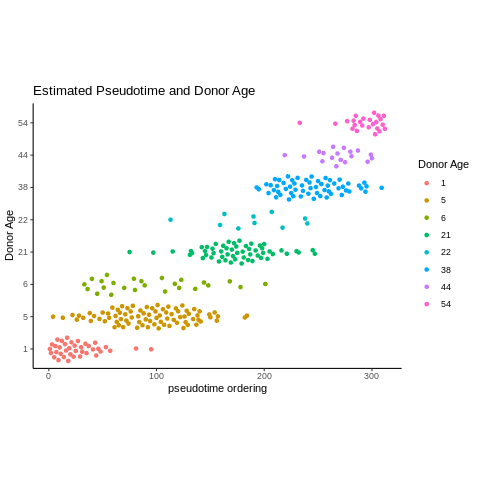

In [35]:
%%R
p<-ggplot(as.data.frame((tt)), aes(x = rank(pseudotimeforuse,ties.method="random"), y = donor_age,
                                                     colour = donor_age, geom_point)) +#   geom_point(size=1)+
  geom_quasirandom(groupOnX = FALSE) +
  scale_color_tableau() + theme_classic()+ coord_fixed(ratio=10)+
  xlab("pseudotime ordering") + ylab("Donor Age") +
  ggtitle("Estimated Pseudotime and Donor Age")+
  coord_fixed(ratio = 30)

p<-p+scale_y_discrete(labels = unique(age))
p<-p+  scale_color_discrete(name = "Donor Age", labels = unique(age))
p